In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from pybaseball import statcast
import seaborn as sns
import requests

In [64]:
import sys, os, importlib

def reload_abs_helper():
    """
    Force reload abs_helper/abs_helper.py and return the ABSHelper class.
    Always pulls the latest version from disk.
    """
    # ensure project root is on sys.path
    sys.path.append(os.path.abspath(".."))

    # import + reload the module
    import abs_helper.abs_helper
    importlib.reload(abs_helper.abs_helper)

    # import the class from the reloaded module
    from abs_helper.abs_helper import ABSHelper
    return ABSHelper


In [1504]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from pybaseball import statcast
import seaborn as sns
import requests
from matplotlib.colors import TwoSlopeNorm

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, GroupKFold, train_test_split
from sklearn.metrics import roc_auc_score, log_loss, make_scorer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from scipy.stats import randint, loguniform, uniform
from sklearn.metrics import f1_score, confusion_matrix, classification_report, brier_score_loss, average_precision_score
import joblib, json

# import sys, os
# sys.path.append(os.path.abspath(".."))  # parent of "notebooks"
# from .modeling.missed_call_model import train_xgb

# import importlib
# from abs_helper import modeling

# importlib.reload(modeling.xgb_clf_model)
# from abs_helper.modeling.xgb_clf_model import train_xgb, calibrate_probs


# import sys, os
# sys.path.append(os.path.abspath(".."))  # add TB_ABS_HELPER to sys.path

# from abs_helper.modeling.xgb_clf_model import train_xgb
# from abs_helper.modeling.xgb_clf_model import calibrate_probs

# importlib.reload(abs_helper.future_states)
# importlib.reload(abs_helper.modeling.xgb_clf_model)
from abs_helper.modeling.xgb_clf_model import train_xgb, calibrate_probs, calibrate_model
from abs_helper.future_states import process_states, add_win_prob_future_states

# Plate is 17 inches wide → half-width in feet
PLATE_HALF_WIDTH = (17 / 2) / 12

# Ball diameter ~2.86 inches → radius in feet
BALL_RADIUS = (2.86 / 2) / 12


class ABSHelper:

    universal_lambda = 0.0058652361809045225

    cat_cols_mcm = ["ump_id", "pitch_type", "pitch_loc", "inning", 'call']
    num_cols_mcm = ["outs_when_up", "pitcher_is_rhand", 'balls', 'strikes', "batter_is_rhand"]
    feature_cols_mcm = cat_cols_mcm + num_cols_mcm
    
    cat_cols_wpm = ['inning_topbot', 'base_state']
    num_cols_wpm = ['inning', 'outs_when_up', 'balls', 'strikes', 'team_bat_score_diff']
    feature_cols_wpm = cat_cols_wpm + num_cols_wpm


    def __init__(self):
        
        self.raw_df = pd.DataFrame()
        self.df = pd.DataFrame()
        self.ump_name_dct = dict()
        self.ump_game_dct = dict()

    def load_raw_data(self, raw_df):
        
        # only select regular season games        
        self.raw_df = raw_df[raw_df['game_type']=='R']
        self.raw_df = self.raw_df.reset_index(drop=True)

    @staticmethod
    def _find_hp_ump_idx(officals_lst):
        for i in range(len(officals_lst)):
            if 'Home Plate' in officals_lst[i].values():
                return i
    
    @staticmethod
    def _get_hp_ump_dct(games):
        game_ump_map = dict()

        for game in games:
            url = f'https://statsapi.mlb.com/api/v1/game/{game}/boxscore'
            r = requests.get(url, timeout=10).json()
            hp_ump_idx = 0
            misidx=0
            officials_values = r['officials'][hp_ump_idx].values()
            if 'Home Plate' not in officials_values:
                hp_ump_idx = ABSHelper._find_hp_ump_idx(r['officials'])
                misidx+=1

            hp_ump = r['officials'][hp_ump_idx]
            hp_ump_id = hp_ump['official']['id']
            hp_ump_name = hp_ump['official']['fullName']

            game_ump_map[int(game)] = {'id': hp_ump_id, 'name': hp_ump_name}
        
        return game_ump_map
    
    @staticmethod
    def _ball_or_strike(row):
        if -PLATE_HALF_WIDTH - BALL_RADIUS <= row['plate_x'] <= PLATE_HALF_WIDTH + BALL_RADIUS:
            szt_lim = row['sz_top'] + BALL_RADIUS
            szb_lim = row['sz_bot'] - BALL_RADIUS

            if szb_lim <= row['plate_z'] <= szt_lim:
                return 'strike'
        
        return 'ball'
    
    def preprocess_data(self):

        # reset index
        df = self.raw_df.reset_index(drop=True)

        # only select pitches where umpire made a choice
        df = df[df['description'].isin(['called_strike','ball'])].dropna(subset=['pitch_type','zone'])

        games = df['game_pk'].unique()

        # create game ID: umpire ID map
        self.ump_game_dct = self._get_hp_ump_dct(games)
        ugd = self.ump_game_dct

        # create umpire ID: Name map 
        self.ump_name_dct = {ugd[game]['id']: ugd[game]['name'] for game in ugd}
        und = self.ump_name_dct

        # assign columns for umpire IDs and names
        df['ump_id'] = df['game_pk'].apply(lambda x: ugd[x]['id'])
        df['ump_name'] = df['game_pk'].apply(lambda x: ugd[x]['name'])

        # select only needed columns
        df = df[[
            'game_date', 'ump_name', 'player_name', 'ump_id', 'pitch_type', 'p_throws', 'inning', 'balls', 'strikes',
            'outs_when_up', 'pitcher','batter', 'stand', 'plate_x','plate_z','sz_top', 'sz_bot', 'zone', 'description',
        ]].copy()
        
        # adjusting data types
        df['description'] = df['description'].map({'called_strike':'strike', 'ball':'ball'})
        df.loc[:, ['p_throws','stand']] = df[['p_throws','stand']] == 'R'

        # changing data types
        df['game_date'] = pd.to_datetime(df['game_date'])
        df['zone'] = df['zone'].astype(int)
        df['balls'] = df['balls'].astype(int)
        df['strikes'] = df['strikes'].astype(int)
        df['inning'] = df['inning'].astype(int)
        df['outs_when_up'] = df['outs_when_up'].astype(int)
        df['sz_top'] = df['sz_top'].astype(float)
        df['sz_bot'] = df['sz_bot'].astype(float)

        # renaming columns
        df = df.rename(columns={'description':'call', 'p_throws':'pitcher_is_rhand', 'stand':'batter_is_rhand'})

        # determining if pitch was a strike or ball
        df['real'] = df.apply(ABSHelper._ball_or_strike, axis=1)
        df['correct'] = df['call'] == df['real']
        df['incorrect'] = ~df['correct']

        z_span = (df['sz_top'] - df['sz_bot']).clip(lower=1e-6)
        z_norm = (df['plate_z'] - df['sz_bot']) / z_span

        sign = np.where(df['batter_is_rhand'], 1.0, -1.0)
        x_signed = df['plate_x'] * sign

        df['pitch_loc_vert'] = pd.cut(z_norm, bins=[-float('inf'), 0.33, 0.66, float('inf')],
                                labels=['low','mid','high']).astype('category')

        df['pitch_loc_horiz'] = pd.cut(x_signed, bins=[-float('inf'), -0.25, 0.25, float('inf')],
                                labels=['away','middle','inside']).astype('category')

        df['pitch_loc'] = (df['pitch_loc_vert'].astype(str) + "_" + df['pitch_loc_horiz'].astype(str)).astype('category')

        self.df = df

    @staticmethod
    def save_dct(dct, path):
        with open(path, 'w') as f:
            json.dump(dct, f)

    @staticmethod
    def load_dct(path, int_keys=False):
        with open(path, "r") as f:
            d = json.load(f)
        if int_keys:
            d = {int(k): v for k, v in d.items()}
        return d

    def calculate_ump_zone_acc(self):
        self.ump_zone_acc = self.df.groupby(['ump_id', 'zone'])['correct'].mean()

    @staticmethod
    def save_series(ser, path):
        # ser.to_frame().to_parquet(path)
        joblib.dump(ser, path)
    
    @staticmethod
    def load_series(path):
        return joblib.load(path)

    def show_ump_heatmap(self, ump_id=None, catcher_perspective=False, ump_zone_acc=None, lg_avg=False):
        if ump_zone_acc is None:
            ump_zone_acc = self.ump_zone_acc
        ump_name_dct = self.ump_name_dct

        if ump_id == None:
            ump_id = int(np.random.choice(list(ump_name_dct.keys())))

        if lg_avg:
            zones = self.df.groupby('zone')['correct'].mean()
            ump_name = 'League Average'
        else:
            zones = ump_zone_acc.loc[ump_id]
            ump_name = ump_name_dct[ump_id]
        small_idx = [1,2,3,4,5,6,7,8,9]
        big_idx   = [11,12,13,14]

        small = zones.reindex(small_idx).to_numpy().reshape(3,3)
        big   = zones.reindex(big_idx).to_numpy().reshape(2,2)

        # Center point for diverging colormap
        # center = float(globals().get("lg_avg", np.nan))
        # if not np.isfinite(center):
        #     center = float(np.nanmean(small))
        center = ump_zone_acc.mean()

        norm = TwoSlopeNorm(vmin=0.50, vcenter=center, vmax=1.00)

        fig, ax = plt.subplots(figsize=(7,7))

        # Geometry (centers aligned)
        pad = 0.35
        big_extent   = [-pad, 2+pad, -pad, 2+pad]
        small_extent = [0, 2, 0, 2]

        # Draw heatmaps
        ax.imshow(big,   extent=big_extent,   origin="upper", cmap="bwr", norm=norm)
        im = ax.imshow(small, extent=small_extent, origin="upper", cmap="bwr", norm=norm)

        # Borders
        ax.plot([big_extent[0], big_extent[1]], [big_extent[2], big_extent[2]], color="k")
        ax.plot([big_extent[0], big_extent[1]], [big_extent[3], big_extent[3]], color="k")
        ax.plot([big_extent[0], big_extent[0]], [big_extent[2], big_extent[3]], color="k")
        ax.plot([big_extent[1], big_extent[1]], [big_extent[2], big_extent[3]], color="k")
        for v in [0, 2/3, 4/3, 2]:
            ax.plot([v, v], [0, 2], color="k")
            ax.plot([0, 2], [v, v], color="k")

        # Labels for 1..9
        zone_nums = np.array(small_idx).reshape(3,3)
        cell_w, cell_h = 2/3, 2/3
        for r in range(3):
            for c in range(3):
                x_left  = c * cell_w
                x_c     = x_left + cell_w/2
                y_top   = 2 - r * cell_h
                y_c     = y_top - cell_h/2

                ax.text(x_left + 0.03, y_top - 0.03,
                        f"{zone_nums[r,c]}",
                        ha="left", va="top", fontsize=11, color="black")
                ax.text(x_c, y_c,
                        f"{small[r,c]:.0%}",
                        ha="center", va="center", fontsize=12, color="black")

        # Percentages for 11–14
        z11, z12, z13, z14 = zones.loc[11], zones.loc[12], zones.loc[13], zones.loc[14]
        tab_y_top, tab_y_bottom = 2 + pad/2, -pad/2
        ax.text(0.5,  tab_y_top,    f"{z11:.0%}", ha="center", va="center", fontsize=12)
        ax.text(1.5,  tab_y_top,    f"{z12:.0%}", ha="center", va="center", fontsize=12)
        ax.text(0.5,  tab_y_bottom, f"{z13:.0%}", ha="center", va="center", fontsize=12)
        ax.text(1.5,  tab_y_bottom, f"{z14:.0%}", ha="center", va="center", fontsize=12)

        # Small zone numbers for 11–14
        ax.text(big_extent[0]+0.04, big_extent[3]-0.04, "11", ha="left",  va="top",    fontsize=10)
        ax.text(big_extent[1]-0.04, big_extent[3]-0.04, "12", ha="right", va="top",    fontsize=10)
        ax.text(big_extent[0]+0.04, big_extent[2]+0.04, "13", ha="left",  va="bottom", fontsize=10)
        ax.text(big_extent[1]-0.04, big_extent[2]+0.04, "14", ha="right", va="bottom", fontsize=10)

        # Perspective flip
        if not catcher_perspective:
            ax.invert_xaxis()

        # Colorbar
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("Correct call rate", rotation=270, labelpad=14)
        cbar.set_ticks([0.5, center, 1.0])
        cbar.set_ticklabels([f"0.50", f"{center:.2f}", "1.00"])

        ax.set_aspect("equal")
        ax.set_xticks([]); ax.set_yticks([])
        plt.tight_layout()
        
        perspective = 'Catcher' if catcher_perspective else 'Pitcher'

        plt.title(f"{ump_name}'s Zone Accuracy - From {perspective}'s Perspective")
        plt.show()

    def prepare_train_test_data_mcm(self, target='incorrect', training_size=.75):
        self.target_mcm = target

        # self.feature_cols_mcm = self.cat_cols_mcm + self.num_cols_mcm

        # Ensure datetime sort
        df = self.df.sort_values("game_date")#.reset_index(drop=True)

        X_all = df[self.feature_cols_mcm].copy()
        y_all = df[self.target_mcm].astype(int).values

        # Hold-out test split by time (e.g., last 20% as test)
        cut = int(len(df) * training_size)
        self.X_train_mcm, self.y_train_mcm = X_all.iloc[:cut], y_all[:cut]
        self.X_test_mcm,  self.y_test_mcm  = X_all.iloc[cut:],  y_all[cut:]

    def train_xgb_clf_model(self, X_train, y_train, cat_cols, num_cols):
        # if not hasattr(self, "X_train"):
        #     raise ValueError("Must call prepare_training_data() before training")

        xgb_clf_model = train_xgb(
            X_train,
            y_train,
            cat_cols,
            num_cols
        )
        return xgb_clf_model
    
    def evaluate_xgb_clf_model(self, xgb_clf_model, X_test, y_test):
        """
        Evaluate the Missed Call Model (mcm) on the hold-out test set.
        Returns a dictionary of metrics.
        """
        # if not hasattr(self, "X_test"):
        #     raise ValueError("Must call prepare_training_data() before evaluation")

        model = xgb_clf_model.best_estimator_ if hasattr(xgb_clf_model, "best_estimator_") else xgb_clf_model

        probs = model.predict_proba(X_test)[:, 1]
        preds = model.predict(X_test)

        results = {
            "roc_auc": roc_auc_score(y_test, probs),
            "log_loss": log_loss(y_test, probs),
            "f1": f1_score(y_test, preds),
            "average_precision": average_precision_score(y_test, probs),
        }

        # Store results on the instance for later use
        self.eval_results = results
        return results
    
    def calibrate_mcm(self, method="isotonic"):
        model = self.mcm.best_estimator_ if hasattr(self.mcm, "best_estimator_") else self.mcm
        self.mcm_calib = calibrate_model(
            model,
            self.X_train_mcm,
            self.y_train_mcm,
            groups=self.X_train_mcm['game_pk'] if 'game_pk' in self.X_train_mcm else None,
            method=method
        )
        return self.mcm_calib

    @staticmethod
    def save_model(model, path):
        joblib.dump(model, path)

    @staticmethod
    def load_model(path):
        return joblib.load(path)

    def make_wp_df(self):

        # sort games so score can be calculated for final play
        sorted_games = self.raw_df.sort_values(['game_pk', 'inning', 'at_bat_number', 'pitch_number'])

        # get final scores of each game to determine winner
        games_scores = sorted_games.groupby('game_pk')[['post_away_score', 'post_home_score']].last()
        games_scores['home_team_win'] = games_scores.apply(lambda x: x['post_home_score'] > x['post_away_score'], axis=1)

        # map for home team winning
        home_won_dict = games_scores['home_team_win'].to_dict()

        data = self.raw_df

        # select only important columns
        wp_df = data[[
            'game_date', 'game_pk', 'away_team', 'home_team', 'inning_topbot', 'inning', 'at_bat_number', 'pitch_number',
            'outs_when_up', 'on_1b', 'on_2b', 'on_3b', 'balls', 'strikes',
            'away_score', 'home_score', 'post_away_score', 'post_home_score'
        ]].copy()

        # make baserunners' presence booleans
        wp_df[['on_1b','on_2b','on_3b']] = wp_df[['on_1b','on_2b','on_3b']].notna().astype(int).astype(str)
        wp_df['on_1b'] = wp_df[['on_1b','on_2b','on_3b']].sum(axis=1)

        # make perspective from team batting
        wp_df['team_bat_score_diff'] = np.where(wp_df['inning_topbot']=='Bot', wp_df['home_score']-wp_df['away_score'], wp_df['away_score']-wp_df['home_score'])

        # assign whether team batting won or lost
        home_won_ser = data['game_pk'].map(home_won_dict).astype(bool)
        wp_df['team_bat_won'] = np.where(data['inning_topbot']=='Bot', home_won_ser, ~home_won_ser)

        # renaming and dropping columns
        wp_df.rename(columns={
            'on_1b': 'base_state'
        }, inplace=True)

        wp_df.drop(columns={
            'on_2b', 'on_3b'
        }, inplace=True)

        self.wp_df = wp_df
        return wp_df

    def prepare_train_test_data_wpm(self, target='team_bat_won', training_size=.75):
        self.target_wpm = target

        wp_df = self.wp_df

        # self.feature_cols_wpm = self.cat_cols_wpm + self.num_cols_wpm

        # Ensure datetime sort
        wp_train_games, wp_test_games = train_test_split(wp_df['game_pk'].unique())

        wp_train_df = wp_df[wp_df['game_pk'].isin(wp_train_games)]
        wp_test_df = wp_df[wp_df['game_pk'].isin(wp_test_games)]

        self.X_train_wpm, self.X_test_wpm, self.y_train_wpm, self.y_test_wpm = wp_train_df[self.feature_cols_wpm], wp_test_df[self.feature_cols_wpm], wp_train_df[self.target_wpm], wp_test_df[self.target_wpm]
    

    def calibrate_wpm(self, method="isotonic"):
        model = self.wpm.best_estimator_ if hasattr(self.wpm, "best_estimator_") else self.wpm
        self.wpm_calib = calibrate_model(
            model,
            self.X_train_wpm,
            self.y_train_wpm,
            groups=None,  # or supply game_pk if available
            method=method
        )
        return self.wpm_calib

    def merge_main(self):
        wp_df = self.wp_df
        df = self.df
        mcm_calib = self.mcm_calib
        wpm_calib = self.wpm_calib
        feature_cols_mcm = self.feature_cols_mcm
        feature_cols_wpm = self.feature_cols_wpm


        merged = wp_df.drop(columns=['inning','outs_when_up', 'balls', 'strikes']).merge(
            df.drop(columns=['game_date']),
            left_index=True,
            right_index=True
        )

        incorrect_call_probs = mcm_calib.predict_proba(merged[feature_cols_mcm])[:, 1]

        win_probs = wpm_calib.predict_proba(merged[feature_cols_wpm])[:, 1]

        merged['events'] = self.raw_df.loc[merged.index, 'events']
        merged['incorrect_call_prob'] = incorrect_call_probs
        merged['win_prob'] = win_probs

        self.merged = merged
        return merged


    
    def make_future_states(self):
        merged = self.merged
        feature_cols_wpm = self.feature_cols_wpm

        # defined masks to make state processing easier
        cs = merged['call'] == 'strike'
        cb = merged['call'] == 'ball'
        inn = merged['inning']
        outs = merged['outs_when_up']
        b = merged['balls']
        s = merged['strikes']
        diff = merged['team_bat_score_diff']
        tb = merged['inning_topbot']
        bs = merged['base_state']

        S, O, S_l, O_l, S_w, O_w = process_states(
            merged=merged,
            feature_cols_wpm=feature_cols_wpm,
            cs=cs,   # mask: called strike
            cb=cb,   # mask: called ball
            outs=outs,
            s=s,     # strikes
            inn=inn, # inning
            diff=diff, # score diff from batting team perspective
            b=b,     # balls
            tb=tb,   # inning_topbot
            bs=bs    # base_state
        )

        # add win probability for future states using model
        for df in (S, O):
            add_win_prob_future_states(df, self.wpm_calib, self.feature_cols_wpm)

        # win probability for these scenarios is a guranteed loss
        for df in (S_l, O_l):
            df.drop(columns = 'inning_topbot_switch', inplace=True)
            df['win_prob'] = 0

        # win probability for these scenarios is a guranteed win
        for df in (S_w, O_w):
            df.drop(columns = 'inning_topbot_switch', inplace=True)
            df['win_prob'] = 1

        self.call_stands_df = pd.concat([S, S_l, S_w])
        self.call_overturned_df = pd.concat([O, O_l, O_w])

    def merge_final(self, include_unneeded_cols=False):
        merged = self.merged
        call_stands_df = self.call_stands_df
        call_overturned_df = self.call_overturned_df
        feature_cols_mcm = self.feature_cols_mcm
        feature_cols_wpm = self.feature_cols_wpm
        remaining_needed_cols = ['call', 'incorrect_call_prob', 'win_prob', 'win_prob_s', 'win_prob_o']
        remaining_unneeded_cols = ['ump_name', 'game_pk', 'events', 'real', 'correct', 'incorrect', 'incorrect_call_prob', 'win_prob']
        cs = merged['call'] == 'strike'

        merged_final = merged.join(call_stands_df['win_prob'].rename('win_prob_s'))
        merged_final = merged_final.join(call_overturned_df['win_prob'].rename('win_prob_o'))
        if include_unneeded_cols:
            merged_final = merged_final[feature_cols_mcm + feature_cols_wpm + remaining_needed_cols + remaining_unneeded_cols]
        else:
            merged_final = merged_final[feature_cols_mcm + feature_cols_wpm + remaining_needed_cols]
        merged_final = merged_final.loc[:, ~merged_final.columns.duplicated()]
        merged_final['win_prob_u'] = np.where(
            cs,
            merged_final['win_prob_o'] - merged_final['win_prob_s'],
            merged_final['win_prob_s'] - merged_final['win_prob_o']
        ).clip(0)

        self.merged_final = merged_final
        return merged_final
    
    @staticmethod
    def calculate_lambda(group):
        group_df = group.copy() #pd.DataFrame()
        group_df['p'] = group['incorrect_call_prob']
        group_df['c'] = 1 - group_df['p']
        group_df['v'] = group_df['p'] * group_df['win_prob_u']
        group_df['r'] = group_df['v'] / group_df['c']
        group_df = group_df.sort_values('r', ascending=False)
        return group_df[group_df['c'].cumsum() <= 2].iloc[-1]['r']

    @staticmethod
    def calculate_delta_we(u, p, lam):
        return (p * u) - (lam * (1-p))

    @staticmethod
    def calculate_cost_mean(df, lam):
        u = df['win_prob_u']
        p = df['incorrect_call_prob']
        positive_we_mask = ABSHelper.calculate_delta_we(u, p, lam) > 0
        
        return df.loc[positive_we_mask]\
        .groupby(['game_pk','inning_topbot'])[['incorrect_call_prob']]\
        .apply(lambda x: (1-x['incorrect_call_prob']).sum(), include_groups=False).mean()
    
    def find_initial_lambda(self):
        lambda_df = self.merged_final[['game_pk', 'inning_topbot', 'incorrect', 'incorrect_call_prob', 'win_prob_u']]
        lambda_groups = lambda_df.groupby(['game_pk', 'inning_topbot']).apply(self.calculate_lambda, include_groups=False)
        return lambda_groups.mean()

    def find_best_lambda(self, lam_range):
        lambda_df = self.merged_final[['game_pk', 'inning_topbot', 'incorrect', 'incorrect_call_prob', 'win_prob_u']]
        cost_means = list()
        for lam in lam_range:
            # positive_we_mask = self.calculate_delta_we(u, p, lam) > 0
            cost_mean = self.calculate_cost_mean(lambda_df, lam)
            cost_means.append(cost_mean)

        cost_means_df = pd.DataFrame()
        cost_means_df.index = lam_range
        cost_means_df['cost_mean'] = cost_means
        cost_means_df['closest'] = (cost_means_df['cost_mean'] - 2).abs()
        cost_means_df.sort_values('closest')
        best_lambda = float(cost_means_df['closest'].idxmin())

        plt.scatter(lam_range, cost_means)
        plt.axhline(2, c='red')

        self.best_lambda = best_lambda
        return best_lambda
    
    def add_delta_we_col(self, lam=None):
        df = self.merged_final
        u = df['win_prob_u']
        p = df['incorrect_call_prob']

        if lam is None:
            lam = self.universal_lambda
        
        df['delta_we'] = self.calculate_delta_we(u, p, lam)
        
        df['challenge'] = df['delta_we'] > 0

    def run_all(self, train_mcm=False, train_wpm=False, best_lambda=None):
        if best_lambda is None:
            best_lambda = self.universal_lambda

        

In [1240]:
# wow = ABSHelper(data)
# wow.merged = test_abs.merged[list(set(test_abs.feature_cols_mcm+test_abs.feature_cols_wpm))].sample(100).copy()
# wow.mcm_calib = wow.load_model('../saved_models/mcm_calib.pkl')
# wow.wpm_calib = wow.load_model('../saved_models/wpm_calib.pkl')
# wow.merged['incorrect_call_prob'] = wow.mcm_calib.predict_proba(wow.merged[wow.feature_cols_mcm])[:,1]
# wow.merged['win_prob'] = wow.wpm_calib.predict_proba(wow.merged[wow.feature_cols_wpm])[:,1]
# wow.add_delta_we_col
# wow.make_future_states()
# wow.merge_final()
# wow.add_delta_we_col()
# # wow.show_ump_heatmap()
# wow.merged_final[['delta_we','challenge']]

,delta_we,challenge
490539,-0.004231,False
527653,-0.004790,False
528448,-0.004893,False
544776,-0.005247,False
534601,-0.004776,False
...,...,...
140161,-0.005005,False
523149,-0.004742,False
79464,-0.005091,False
248715,0.001952,True


In [1252]:
data = statcast('2025-03-01','2025-09-28')

This is a large query, it may take a moment to complete


c:\Users\tyism\AppData\Local\Programs\Python\Python313\Lib\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates


  0%|          | 0/198 [00:00<?, ?it/s]c:\Users\tyism\AppData\Local\Programs\Python\Python313\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  1%|          | 2/198 [00:01<02:32,  1.29it/s]c:\Users\tyism\AppData\Local\Programs\Python\Python313\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  2%|▏         | 3/198 [00:01<01:57,  1.66it/s]c:\Users\tyism\AppData\Local\Programs\Python\Python313\Lib\site-packages\pybaseball\datahelpers\postprocessin

In [1505]:
test_abs = ABSHelper()

In [1506]:
test_abs.load_raw_data(data)

In [1403]:
# test_abs.preprocess_data()

In [ ]:
# temp_df = test_abs.df.copy()
# temp_ugd = test_abs.ump_game_dct
# temp_und = test_abs.ump_name_dct
# temp_uza = test_abs.ump_zone_acc.copy()

In [ ]:
# test_abs.df = temp_df.copy()
# test_abs.ump_game_dct = temp_ugd
# test_abs.ump_name_dct = temp_und
# test_abs.ump_zone_acc = temp_uza.copy()

In [ ]:
# test_abs.save_dct(test_abs.ump_game_dct, '../saved_dcts/ump_game_dct.json')
# test_abs.save_dct(test_abs.ump_name_dct, '../saved_dcts/ump_name_dct.json')
# test_abs.save_series(test_abs.ump_zone_acc, '../saved_dcts/ump_zone_acc.joblib')

In [1512]:
test_abs.ump_game_dct = test_abs.load_dct('../saved_dcts/ump_game_dct.json')
test_abs.ump_name_dct = test_abs.load_dct('../saved_dcts/ump_name_dct.json', int_keys=True)
test_abs.ump_zone_acc = test_abs.load_series('../saved_dcts/ump_zone_acc.joblib')

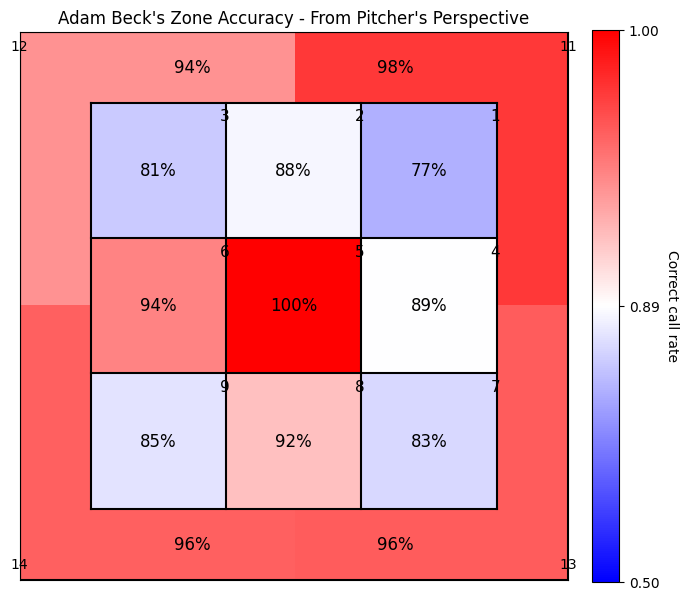

In [1515]:
test_abs.show_ump_heatmap()

In [1412]:
test_abs.prepare_train_test_data_mcm()

In [1413]:
# test_abs.mcm = test_abs.train_xgb_clf_model(
#     test_abs.X_train_mcm,
#     test_abs.y_train_mcm,
#     test_abs.cat_cols_mcm,
#     test_abs.num_cols_mcm,
# )

In [1414]:
test_abs.mcm = test_abs.load_model('../saved_models/mcm.pkl')

In [1415]:
test_abs.evaluate_xgb_clf_model(test_abs.mcm, test_abs.X_test_mcm, test_abs.y_test_mcm)

{'roc_auc': np.float64(0.6615680337432503),
 'log_loss': 0.4290067124686209,
 'f1': 0.1652569941444372,
 'average_precision': np.float64(0.13276726186022084)}

In [1416]:
print(classification_report(test_abs.y_test_mcm, test_abs.mcm.predict(test_abs.X_test_mcm)))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     81309
           1       0.16      0.17      0.17      6572

    accuracy                           0.87     87881
   macro avg       0.55      0.55      0.55     87881
weighted avg       0.87      0.87      0.87     87881



In [1417]:
# test_abs.calibrate_mcm()

In [1418]:
test_abs.mcm_calib = test_abs.load_model('../saved_models/mcm_calib.pkl')

In [1419]:
test_abs.mcm_calib.predict_proba(test_abs.X_test_mcm)[:,1].mean()

np.float64(0.07426254694328009)

In [1420]:
# test_abs.save_model(test_abs.mcm, '../saved_models/mcm.pkl')

In [1421]:
# test_abs.save_model(test_abs.mcm_calib, '../saved_models/mcm_calib.pkl')

In [1422]:
test_abs.make_wp_df()

,game_date,game_pk,away_team,home_team,inning_topbot,inning,at_bat_number,pitch_number,outs_when_up,base_state,balls,strikes,away_score,home_score,post_away_score,post_home_score,team_bat_score_diff,team_bat_won
0,2025-09-27,776164,STL,CHC,Top,9,74,6,2,111,3,2,3,7,3,7,-4,False
1,2025-09-27,776164,STL,CHC,Top,9,74,5,2,111,3,1,3,7,3,7,-4,False
2,2025-09-27,776164,STL,CHC,Top,9,74,4,2,111,3,0,3,7,3,7,-4,False
3,2025-09-27,776164,STL,CHC,Top,9,74,3,2,111,2,0,3,7,3,7,-4,False
4,2025-09-27,776164,STL,CHC,Top,9,74,2,2,111,1,0,3,7,3,7,-4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705626,2025-03-18,778563,LAD,CHC,Top,1,2,2,1,000,1,0,0,0,0,0,0,True
705627,2025-03-18,778563,LAD,CHC,Top,1,2,1,1,000,0,0,0,0,0,0,0,True
705628,2025-03-18,778563,LAD,CHC,Top,1,1,3,0,000,1,1,0,0,0,0,0,True
705629,2025-03-18,778563,LAD,CHC,Top,1,1,2,0,000,0,1,0,0,0,0,0,True


In [1423]:
test_abs.prepare_train_test_data_wpm()

In [1424]:
# test_abs.wpm = test_abs.train_xgb_clf_model(
#     test_abs.X_train_wpm,
#     test_abs.y_train_wpm,
#     test_abs.cat_cols_wpm,
#     test_abs.num_cols_wpm
# )

In [1426]:
# test_abs.calibrate_wpm()

In [1427]:
# test_abs.save_model(test_abs.wpm, '../saved_models/wpm.pkl')

In [1428]:
# test_abs.save_model(test_abs.wpm_calib, '../saved_models/wpm_calib.pkl')

In [1429]:
test_abs.wpm = test_abs.load_model('../saved_models/wpm.pkl')

In [1431]:
test_abs.evaluate_xgb_clf_model(test_abs.wpm, test_abs.X_test_wpm, test_abs.y_test_wpm)

{'roc_auc': np.float64(0.8503799531729456),
 'log_loss': 0.5113423728465315,
 'f1': 0.6656642550350956,
 'average_precision': np.float64(0.8616784239406279)}

In [1432]:
print(classification_report(test_abs.y_test_wpm, test_abs.wpm.predict(test_abs.X_test_wpm)))


              precision    recall  f1-score   support

       False       0.65      0.91      0.76     86150
        True       0.86      0.54      0.67     90979

    accuracy                           0.72    177129
   macro avg       0.76      0.73      0.71    177129
weighted avg       0.76      0.72      0.71    177129



In [1433]:
test_abs.wpm_calib = test_abs.load_model('../saved_models/wpm_calib.pkl')

In [1434]:
test_abs.merge_main()

,game_date,game_pk,away_team,home_team,inning_topbot,at_bat_number,pitch_number,base_state,away_score,home_score,...,call,real,correct,incorrect,pitch_loc_vert,pitch_loc_horiz,pitch_loc,events,incorrect_call_prob,win_prob
2,2025-09-27,776164,STL,CHC,Top,74,4,111,3,7,...,strike,ball,False,True,high,inside,high_inside,NaN,0.147639,0.063169
3,2025-09-27,776164,STL,CHC,Top,74,3,111,3,7,...,ball,ball,True,False,high,inside,high_inside,NaN,0.091763,0.062744
4,2025-09-27,776164,STL,CHC,Top,74,2,111,3,7,...,ball,ball,True,False,low,away,low_away,NaN,0.079751,0.061286
5,2025-09-27,776164,STL,CHC,Top,74,1,111,3,7,...,ball,ball,True,False,low,away,low_away,NaN,0.089499,0.055086
6,2025-09-27,776164,STL,CHC,Top,73,6,110,3,7,...,ball,ball,True,False,low,inside,low_inside,walk,0.060758,0.016808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705620,2025-03-18,778563,LAD,CHC,Bot,4,3,000,0,0,...,ball,ball,True,False,low,away,low_away,NaN,0.083007,0.617753
705621,2025-03-18,778563,LAD,CHC,Bot,4,2,000,0,0,...,ball,ball,True,False,low,inside,low_inside,NaN,0.076884,0.613997
705627,2025-03-18,778563,LAD,CHC,Top,2,1,000,0,0,...,ball,ball,True,False,low,away,low_away,NaN,0.050862,0.428165
705629,2025-03-18,778563,LAD,CHC,Top,1,2,000,0,0,...,ball,ball,True,False,low,inside,low_inside,NaN,0.040947,0.444720


In [1435]:
test_abs.make_future_states()

In [1436]:
test_abs.merge_final(True)

,ump_id,pitch_type,pitch_loc,inning,call,outs_when_up,pitcher_is_rhand,balls,strikes,batter_is_rhand,...,win_prob,win_prob_s,win_prob_o,ump_name,game_pk,events,real,correct,incorrect,win_prob_u
2,577468,FF,high_inside,9,strike,2,True,3,0,False,...,0.063169,0.051566,0.068674,Roberto Ortiz,776164,NaN,ball,False,True,0.017108
3,577468,FF,high_inside,9,ball,2,True,2,0,False,...,0.062744,0.063169,0.050448,Roberto Ortiz,776164,NaN,ball,True,False,0.012721
4,577468,FF,low_away,9,ball,2,True,1,0,False,...,0.061286,0.062744,0.050448,Roberto Ortiz,776164,NaN,ball,True,False,0.012296
5,577468,FF,low_away,9,ball,2,True,0,0,False,...,0.055086,0.061286,0.043259,Roberto Ortiz,776164,NaN,ball,True,False,0.018027
6,577468,FF,low_inside,9,ball,2,True,3,2,True,...,0.016808,0.068674,0.000000,Roberto Ortiz,776164,walk,ball,True,False,0.068674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705620,427344,FF,low_away,1,ball,0,True,2,0,False,...,0.617753,0.628645,0.613997,Bill Miller,778563,NaN,ball,True,False,0.014648
705621,427344,FF,low_inside,1,ball,0,True,1,0,False,...,0.613997,0.617753,0.608499,Bill Miller,778563,NaN,ball,True,False,0.009255
705627,427344,FS,low_away,1,ball,1,False,0,0,True,...,0.428165,0.436911,0.425183,Bill Miller,778563,NaN,ball,True,False,0.011728
705629,427344,SL,low_inside,1,ball,0,False,0,1,False,...,0.444720,0.446422,0.441527,Bill Miller,778563,NaN,ball,True,False,0.004895


In [1437]:
test_abs.add_delta_we_col()

In [1438]:
test_abs.merged_final['challenge'].mean()

np.float64(0.02216083818605432)

In [1445]:
test_abs.calculate_cost_mean(test_abs.merged_final, test_abs.universal_lambda)

np.float64(2.0006497625132873)

In [ ]:
# test_abs.df = temp_df
# test_abs.ump_name_dct = temp_und
# test_abs.ump_game_dct = temp_ugd
# test_abs.calculate_ump_zone_acc()
# test_abs.prepare_train_test_data_mcm()
# test_abs.mcm = test_abs.load_model('../saved_models/mcm.pkl')
# test_abs.mcm_calib = test_abs.load_model('../saved_models/mcm_calib.pkl')
# test_abs.make_wp_df()
# test_abs.prepare_train_test_data_wpm()
# test_abs.wpm = test_abs.load_model('../saved_models/wpm.pkl')
# test_abs.wpm_calib = test_abs.load_model('../saved_models/wpm_calib.pkl')
# test_abs.merge_main()
# test_abs.make_future_states()
# test_abs.merge_final(True)
# test_abs.best_lambda = temp_lambda
# test_abs.add_delta_we_col()

In [ ]:
# test_abs.calculate_cost_mean(test_abs.merged_final, test_abs.universal_lambda)

np.float64(1.9920226381126223)

In [ ]:
# test_mcm = test_abs.train_xgb_clf_model(
#     test_abs.X_train_mcm,
#     test_abs.y_train_mcm,
#     test_abs.cat_cols_mcm,
#     test_abs.num_cols_mcm,
# )

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [ ]:
# test_abs.evaluate_xgb_clf_model(test_mcm, test_abs.X_test_mcm, test_abs.y_test_mcm)

{'roc_auc': np.float64(0.6672860575028761),
 'log_loss': 0.4288846232135575,
 'f1': 0.17463235294117646,
 'average_precision': np.float64(0.13702734835991237)}

In [ ]:
# test_abs.evaluate_xgb_clf_model(test_mcm, test_abs.X_test_mcm, test_abs.y_test_mcm)

{'roc_auc': np.float64(0.7823606499848801),
 'log_loss': 0.37635185264776866,
 'f1': 0.31307550644567217,
 'average_precision': np.float64(0.2574946365424907)}

In [ ]:
# print(classification_report(test_abs.y_test_mcm, test_mcm.predict(test_abs.X_test_mcm)))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     69132
           1       0.17      0.19      0.17      5647

    accuracy                           0.87     74779
   macro avg       0.55      0.55      0.55     74779
weighted avg       0.87      0.87      0.87     74779



In [ ]:
# test_abs.save_model(test_abs.mcm, '../saved_models/mcm.pkl')

In [ ]:
# test_abs.mcm = test_abs.load_model('../saved_models/mcm.pkl')

In [ ]:
# test_abs.evaluate_xgb_clf_model(test_abs.mcm, test_abs.X_test_mcm, test_abs.y_test_mcm)

{'roc_auc': np.float64(0.7823606499848801),
 'log_loss': 0.37635185264776866,
 'f1': 0.31307550644567217,
 'average_precision': np.float64(0.2574946365424907)}

In [ ]:
# ABSHelper = reload_abs_helper()

In [63]:
# test_abs.calibrate_model_probs()

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


CalibratedClassifierCV(estimator=RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                                                    estimator=Pipeline(steps=[('prep',
                                                                               ColumnTransformer(transformers=[('cat',
                                                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                                                ['ump_id',
                                                                                                                 'pitch_type',
                                                                                                                 'count',
                                                                                                                 'zone',
                                                                                                                 'inning']),
                                                                                                               ('num',
                                                                                                                'passthrough',
                                                                                                                ['outs_when_up',
                                                                                                                 'pitcher_is_rhand',
                                                                                                                 'batter_i...
                                                                                               400,
                                                                                               600,
                                                                                               800],
                                                                         'clf__reg_alpha': [0.0,
                                                                                            0.1,
                                                                                            0.5,
                                                                                            1.0],
                                                                         'clf__reg_lambda': [0.5,
                                                                                             1.0,
                                                                                             2.0,
                                                                                             5.0,
                                                                                             10.0],
                                                                         'clf__scale_pos_weight': [1.0,
                                                                                                   np.float64(6.18220540926963),
                                                                                                   np.float64(12.36441081853926),
                                                                                                   np.float64(18.54661622780889),
                                                                                                   np.float64(24.72882163707852)],
                                                                         'clf__subsample': [0.7,
                                                                                            0.8,
                                                                                            0.9,
                                                                                            1.0]},
                                                    random_state=4

In [1137]:
# test_abs.calibrate_mcm()

CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('prep',
                                                  ColumnTransformer(transformers=[('cat',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['ump_id',
                                                                                    'pitch_type',
                                                                                    'pitch_loc',
                                                                                    'inning',
                                                                                    'call']),
                                                                                  ('num',
                                                                                   'passthrough',
                                                                                   ['outs_when_up',
                                                                                    'pitcher_is_rhand',
                                                                                    'balls',
                                                                                    'strikes',
                                                                                    'batter_is_rhand'])])),
                                                 ('clf',
                                                  XGBClassifier(base_score=None,
                                                                booster=None,
                                                                callbacks=...
                                                                gamma=None,
                                                                grow_policy=None,
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                learning_rate=0.02,
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=6,
                                                                max_leaves=None,
                                                                min_child_weight=None,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=200,
                                                                n_jobs=-1,
                                                                num_parallel_tree=None, ...))]),
                       method='isotonic')

In [ ]:
# test_abs.save_model(test_abs.mcm_calib, '../saved_models/mcm_calib.pkl')

In [1141]:
test_abs.mcm_calib = test_abs.load_model('../saved_models/mcm_calib.pkl')

In [1142]:
test_preds = test_abs.mcm_calib.predict(test_abs.X_test_mcm)
print(classification_report(test_abs.y_test_mcm, test_preds))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     69132
           1       0.46      0.00      0.00      5647

    accuracy                           0.92     74779
   macro avg       0.69      0.50      0.48     74779
weighted avg       0.89      0.92      0.89     74779



In [1139]:
probs = test_abs.mcm_calib.predict_proba(test_abs.X_test_mcm)[:, 1]
print("TIME TEST AUC:", roc_auc_score(test_abs.y_test_mcm, probs))

TIME TEST AUC: 0.6676569317361178


In [218]:
test_abs.make_wp_df()

,game_date,game_pk,away_team,home_team,inning_topbot,inning,at_bat_number,pitch_number,outs_when_up,base_state,balls,strikes,away_score,home_score,post_away_score,post_home_score,team_bat_score_diff,team_bat_won
0,2025-08-31,776522,ATL,PHI,Bot,9,73,3,2,000,0,2,3,1,3,1,-2,False
1,2025-08-31,776522,ATL,PHI,Bot,9,73,2,2,000,0,1,3,1,3,1,-2,False
2,2025-08-31,776522,ATL,PHI,Bot,9,73,1,2,000,0,0,3,1,3,1,-2,False
3,2025-08-31,776522,ATL,PHI,Bot,9,72,3,1,000,0,2,3,1,3,1,-2,False
4,2025-08-31,776522,ATL,PHI,Bot,9,72,2,1,000,0,1,3,1,3,1,-2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644071,2025-03-15,778698,MIN,ATL,Top,1,2,1,1,000,0,0,0,0,0,0,0,False
644072,2025-03-15,778698,MIN,ATL,Top,1,1,4,0,000,1,2,0,0,0,0,0,False
644073,2025-03-15,778698,MIN,ATL,Top,1,1,3,0,000,1,1,0,0,0,0,0,False
644074,2025-03-15,778698,MIN,ATL,Top,1,1,2,0,000,1,0,0,0,0,0,0,False


In [219]:
test_abs.prepare_train_test_data_wpm()

In [220]:
# test_abs.wpm = test_abs.train_xgb_clf_model(
#     test_abs.X_train_wpm,
#     test_abs.y_train_wpm,
#     test_abs.cat_cols_wpm,
#     test_abs.num_cols_wpm
# )

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [ ]:
# test_abs.save_model(test_abs.wpm, '../saved_models/wpm.pkl')

In [521]:
test_abs.wpm = test_abs.load_model('../saved_models/wpm.pkl')

In [522]:
# test_abs.calibrate_wpm()

CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('prep',
                                                  ColumnTransformer(transformers=[('cat',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['inning_topbot',
                                                                                    'base_state']),
                                                                                  ('num',
                                                                                   'passthrough',
                                                                                   ['inning',
                                                                                    'outs_when_up',
                                                                                    'balls',
                                                                                    'strikes',
                                                                                    'team_bat_score_diff'])])),
                                                 ('clf',
                                                  XGBClassifier(base_score=None,
                                                                booster=None,
                                                                callbacks=None,
                                                                colsample_bylevel=None...
                                                                gamma=None,
                                                                grow_policy=None,
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                learning_rate=0.02,
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=3,
                                                                max_leaves=None,
                                                                min_child_weight=None,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=800,
                                                                n_jobs=-1,
                                                                num_parallel_tree=None, ...))]),
                       method='isotonic')

In [ ]:
# test_abs.save_model(test_abs.wpm_calib, '../saved_models/wpm_calib.pkl')

In [540]:
test_abs.wpm_calib = test_abs.load_model('../saved_models/wpm_calib.pkl')

In [225]:
test_abs.evaluate_xgb_clf_model(test_abs.wpm, test_abs.X_test_wpm, test_abs.y_test_wpm)

{'roc_auc': np.float64(0.8299868407717864),
 'log_loss': 0.5407697557858856,
 'f1': 0.7602672651229215,
 'average_precision': np.float64(0.8333492102029332)}

In [543]:
test_abs.evaluate_xgb_clf_model(test_abs.wpm_calib, test_abs.X_test_wpm, test_abs.y_test_wpm)

{'roc_auc': np.float64(0.8443866078897819),
 'log_loss': 0.48351318165817336,
 'f1': 0.753751906706687,
 'average_precision': np.float64(0.8504025914125524)}

In [226]:
test_preds = test_abs.wpm.predict(test_abs.X_test_wpm)
print(classification_report(test_abs.y_test_wpm, test_preds))

              precision    recall  f1-score   support

       False       0.84      0.50      0.63     79177
        True       0.65      0.91      0.76     81841

    accuracy                           0.71    161018
   macro avg       0.75      0.70      0.69    161018
weighted avg       0.75      0.71      0.69    161018



In [542]:
test_preds = test_abs.wpm_calib.predict(test_abs.X_test_wpm)
print(classification_report(test_abs.y_test_wpm, test_preds))

              precision    recall  f1-score   support

       False       0.74      0.76      0.75     79203
        True       0.77      0.74      0.75     82545

    accuracy                           0.75    161748
   macro avg       0.75      0.75      0.75    161748
weighted avg       0.75      0.75      0.75    161748



In [240]:
test_abs.merge_main()

,game_date,game_pk,away_team,home_team,inning_topbot,at_bat_number,pitch_number,base_state,balls,strikes,...,sz_top,sz_bot,zone,call,real,correct,incorrect,events,incorrect_call_prob,win_prob
1,2025-08-31,776522,ATL,PHI,Bot,73,2,000,0,1,...,3.19,1.53,1,strike,strike,True,False,NaN,0.749297,0.187913
2,2025-08-31,776522,ATL,PHI,Bot,73,1,000,0,0,...,3.30,1.62,4,strike,strike,True,False,NaN,0.341375,0.188319
5,2025-08-31,776522,ATL,PHI,Bot,72,1,000,0,0,...,3.15,1.50,2,strike,strike,True,False,NaN,0.257225,0.263015
9,2025-08-31,776522,ATL,PHI,Bot,71,2,000,1,0,...,3.88,1.89,9,strike,strike,True,False,NaN,0.487089,0.313578
10,2025-08-31,776522,ATL,PHI,Bot,71,1,000,0,0,...,3.96,1.99,13,ball,ball,True,False,NaN,0.382280,0.307824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600105,2025-03-25,787997,LAD,LAA,Top,39,5,000,2,2,...,3.52,1.63,14,ball,ball,True,False,field_out,0.275195,0.718251
600106,2025-03-25,787997,LAD,LAA,Top,39,4,000,1,2,...,3.52,1.63,13,ball,ball,True,False,NaN,0.397841,0.715963
600112,2025-03-25,787997,LAD,LAA,Bot,38,1,000,0,0,...,3.26,1.50,13,ball,ball,True,False,NaN,0.160551,0.609119
600114,2025-03-25,787997,LAD,LAA,Bot,37,2,000,1,0,...,3.40,1.62,13,ball,ball,True,False,NaN,0.214763,0.640906


In [261]:
test_abs.make_future_states()

In [278]:
test_abs.merge_final()

,ump_id,pitch_type,count,zone,inning,outs_when_up,pitcher_is_rhand,batter_is_rhand,sz_top,sz_bot,...,call,real,correct,incorrect,events,incorrect_call_prob,win_prob,win_prob_s,win_prob_o,win_prob_u
1,547380,FF,0-1,1,9,2,True,False,3.19,1.53,...,strike,strike,True,False,NaN,0.749297,0.187913,0.170677,0.190459,0.019783
2,547380,SI,0-0,4,9,2,True,False,3.30,1.62,...,strike,strike,True,False,NaN,0.341375,0.188319,0.187913,0.190766,0.002853
5,547380,SI,0-0,2,9,1,True,True,3.15,1.50,...,strike,strike,True,False,NaN,0.257225,0.263015,0.261988,0.268256,0.006268
9,547380,SI,1-0,9,9,0,True,True,3.88,1.89,...,strike,strike,True,False,NaN,0.487089,0.313578,0.311954,0.324528,0.012575
10,547380,SI,0-0,13,9,0,True,True,3.96,1.99,...,ball,ball,True,False,NaN,0.382280,0.307824,0.313578,0.306074,0.007504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600105,427344,FF,2-0,14,1,0,True,False,3.52,1.63,...,ball,ball,True,False,field_out,0.275195,0.718251,0.729718,0.702526,0.027192
600106,427344,FF,1-0,13,1,0,True,False,3.52,1.63,...,ball,ball,True,False,NaN,0.397841,0.715963,0.718251,0.702526,0.015725
600112,427344,FS,0-0,13,1,1,False,True,3.26,1.50,...,ball,ball,True,False,NaN,0.160551,0.609119,0.614987,0.606289,0.008698
600114,427344,SL,0-1,13,1,0,False,False,3.40,1.62,...,ball,ball,True,False,NaN,0.214763,0.640906,0.649631,0.637648,0.011983


In [558]:
test_abs.find_initial_lambda()

np.float64(0.007285108382320045)

In [871]:
test_abs.find_initial_lambda()

np.float64(0.007349871300348246)

In [570]:
lam_center = 0.00525
lam_spread = .00001
lam_n = 200
lam_range = np.linspace(lam_center-lam_spread, lam_center+lam_spread, lam_n)
# lam_range = np.arange(.004, .0053, .00001)
# print(len(lam_range))
lam_range

array([0.00524   , 0.0052401 , 0.0052402 , 0.0052403 , 0.0052404 ,
       0.0052405 , 0.0052406 , 0.0052407 , 0.0052408 , 0.0052409 ,
       0.00524101, 0.00524111, 0.00524121, 0.00524131, 0.00524141,
       0.00524151, 0.00524161, 0.00524171, 0.00524181, 0.00524191,
       0.00524201, 0.00524211, 0.00524221, 0.00524231, 0.00524241,
       0.00524251, 0.00524261, 0.00524271, 0.00524281, 0.00524291,
       0.00524302, 0.00524312, 0.00524322, 0.00524332, 0.00524342,
       0.00524352, 0.00524362, 0.00524372, 0.00524382, 0.00524392,
       0.00524402, 0.00524412, 0.00524422, 0.00524432, 0.00524442,
       0.00524452, 0.00524462, 0.00524472, 0.00524482, 0.00524492,
       0.00524503, 0.00524513, 0.00524523, 0.00524533, 0.00524543,
       0.00524553, 0.00524563, 0.00524573, 0.00524583, 0.00524593,
       0.00524603, 0.00524613, 0.00524623, 0.00524633, 0.00524643,
       0.00524653, 0.00524663, 0.00524673, 0.00524683, 0.00524693,
       0.00524704, 0.00524714, 0.00524724, 0.00524734, 0.00524

0.005247236180904523

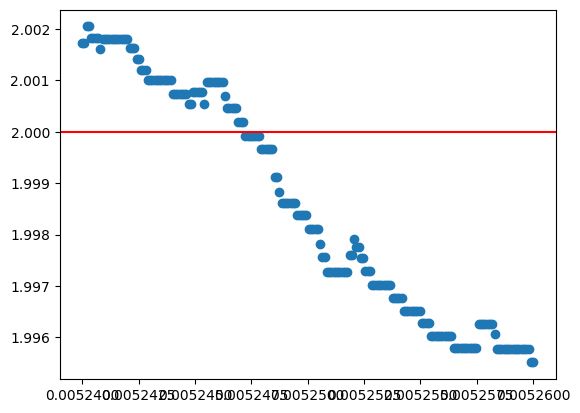

In [571]:
test_abs.find_best_lambda(lam_range)

In [572]:
test_abs.best_lambda

0.005247236180904523

In [573]:
test_abs.calculate_cost_mean(test_abs.merged_final, test_abs.best_lambda)

np.float64(1.999921845302024)

In [888]:
test_abs.calculate_cost_mean(test_abs.merged_final, test_abs.universal_lambda)

np.float64(1.9223172024831212)

In [887]:
test_abs.best_lambda, test_abs.best_lambda-.00023

(0.005247236180904523, 0.005017236180904523)

In [574]:
test_abs.calculate_cost_mean(test_abs.merged_final, 0.008067484663017672)

np.float64(1.3960359331516283)

In [725]:
test_abs.add_delta_we_col()

In [1152]:
test_abs.merged_final['challenge'].mean()

np.float64(0.019865335624544487)

In [1146]:
sits = pd.cut(
    test_abs.merged_final['team_bat_score_diff'],
    bins=[-float('inf'), -7.5, -3.5, -0.5, 0.5, 3.5, 7.5, float('inf')],
    labels=['down blow out', 'down big', 'down close', 'tie','up close','up big', 'up blow out']
)


In [1147]:
test_merged = test_abs.merged_final[['ump_name', 'inning', 'inning_topbot', 'team_bat_score_diff', 'call', 'challenge', 'delta_we']].copy()
test_merged['sits'] = sits
sits_chal_perc = test_merged.groupby(['inning', 'sits'], observed=False)[['challenge']].agg(['mean','count']).sort_values(('challenge', 'mean'), ascending=False)
sits_dwe_mean = test_merged.groupby(['inning', 'sits'], observed=False)[['delta_we']].agg(lambda x: np.percentile(x, 99.9)).sort_values('delta_we', ascending=False)

In [815]:
sits_chal_perc[sits_chal_perc[('challenge','count')]>=500]

challenge       
                          mean  count
inning sits                          
10     tie            0.088636   1320
9      tie            0.061432   3044
       down close     0.056055   7564
7      tie            0.055395   4152
1      down close     0.050012   4219
8      tie            0.047693   3858
6      down close     0.045584   9477
       tie            0.045236   4775
2      down close     0.041335   8540
8      down close     0.041297   9008
5      tie            0.039504   6126
3      tie            0.038347  10092
4      tie            0.038176   7282
7      down close     0.037833   8934
1      tie            0.037761  25476
3      down close     0.036794   9920
4      down close     0.036355   9985
5      down close     0.036156   9542
2      tie            0.034971  14555
1      up close       0.030863   4925
2      up close       0.027943   8768
9      down big       0.026035   5147
2      down big       0.025540   1018
6      up close       0.024141   9693
3      up close       0.020768   9919
4      up close       0.020325   9545
7      up close       0.020213   9301
4      down big       0.018770   2504
9      down blow out  0.017604   1761
5      up close       0.016862   9963
3      down big       0.016615   1926
7      down big       0.016500   4303
6      down big       0.016365   4033
7      down blow out  0.015857   1009
8      down big       0.015216   4666
5      down blow out  0.015209    526
9      up close       0.015039   4189
8      down blow out  0.013534   1330
5      down big       0.012464   3129
8      up close       0.012271   8801
6      down blow out  0.011696    684
5      up blow out    0.011009    545
4      up big         0.006197   2582
3      up big         0.005780   1903
2      up big         0.005025    995
5      up big         0.004435   3608
7      up blow out    0.004340   1152
8      up blow out    0.004021   1492
7      up big         0.003885   4891
8      up big         0.003667   5181
6      up big         0.001926   4153
       up blow out    0.001348    742
9      up blow out    0.001242    805
       up big         0.000430   2327

In [697]:
ump_zone_acc_pred = test_abs.merged_final.groupby(['ump_id', 'zone'])['incorrect_call_prob'].agg(lambda x: (1-x).mean())

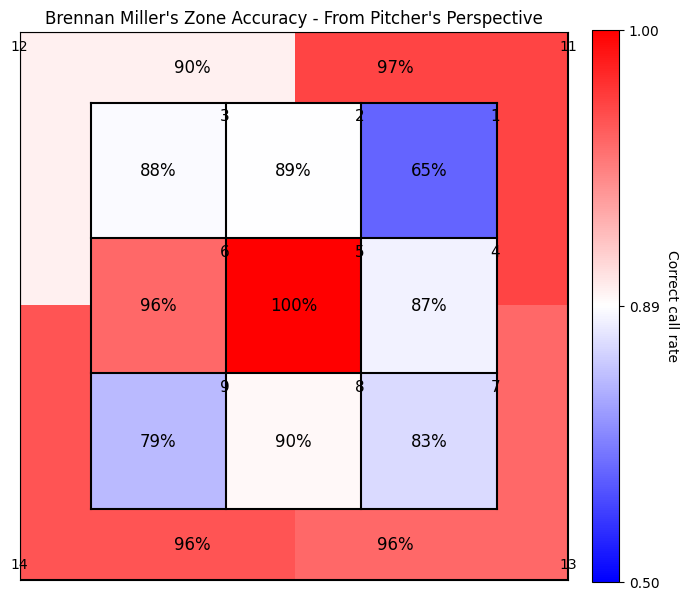

In [703]:
test_abs.show_ump_heatmap(ump_id = 639723)

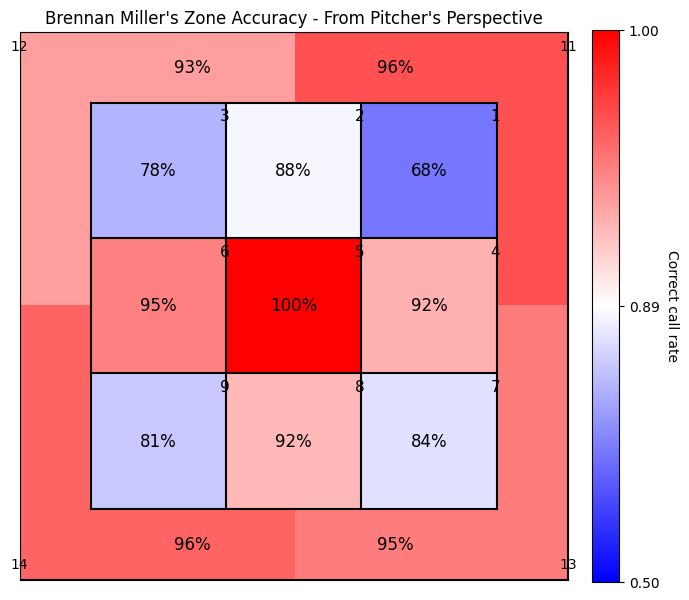

In [706]:
test_abs.show_ump_heatmap(ump_zone_acc = ump_zone_acc_pred, ump_id = 639723)

In [1243]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # pick distinct colors for buckets
# bucket_palette = {
#     "low_away": "red",
#     "low_middle": "orange",
#     "low_inside": "gold",
#     "mid_away": "blue",
#     "mid_middle": "purple",
#     "mid_inside": "cyan",
#     "high_away": "green",
#     "high_middle": "lime",
#     "high_inside": "pink"
# }

# sns.scatterplot(
#     data=test_abs.df[test_abs.df['batter_is_rhand']].sample(10000),
#     x='plate_x', y='plate_z',
#     hue='loc_bucket',
#     palette=bucket_palette
# )
# plt.axhline(0, color="k", lw=1)
# plt.axvline(0, color="k", lw=1)
# plt.show()


ValueError: Could not interpret value `loc_bucket` for `hue`. An entry with this name does not appear in `data`.